# Imports

In [1]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB



# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

# Reading the Dataset

In [2]:
with pd.read_json('data//Podcast reviews//reviews.json', lines=True, chunksize=100000) as chunks:
    df = pd.DataFrame()  # Initialize an empty DataFrame outside the loop
    for chunk in chunks:
        df = pd.concat([df, chunk])  # Concatenate each chunk to the existing df


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5607021 entries, 0 to 5607020
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   podcast_id  object             
 1   title       object             
 2   content     object             
 3   rating      int64              
 4   author_id   object             
 5   created_at  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 256.7+ MB


# Adjusting the dataset for Binary Classification

In [7]:
df.loc[df['rating'] == 2, 'rating'] = 1

In [9]:
df[df['rating'] == 1].shape[0]

419142

In [10]:
df[df['rating'] == 1].head()

,podcast_id,title,content,rating,author_id,created_at
0,52e3d2c4fab4e80a8bb75ad144671d96,Argh,What the heck is this show? And why can’t I de...,1,a23655ce5565f32,2019-05-01 01:24:01+00:00
1,52e3d2c4fab4e80a8bb75ad144671d96,Miss gross overrated as interviewer.,The Howard stern interview was horrible. I lea...,1,e5d461c5f91c8d2,2019-06-07 14:25:34+00:00
7,52e3d2c4fab4e80a8bb75ad144671d96,"Abrasive, tone-deaf Terry",Someone please sit this woman down and recalib...,1,92fccd361c71fd6,2019-04-01 14:32:56+00:00
10,52e3d2c4fab4e80a8bb75ad144671d96,Howard Stern Pt 2,Tired of the interviews of guys who brought us...,1,d92f7a67d9566f2,2019-05-15 21:27:21+00:00
14,52e3d2c4fab4e80a8bb75ad144671d96,General,When will your inept IT group fix the problem....,1,c4031bc7780f013,2019-05-12 02:32:43+00:00


In [12]:
# Drop rows where rating is 3 or 4
df = df.drop(df[df['rating'].isin([3, 4])].index)

In [14]:
df_5 = df[df['rating'] == 5]

In [15]:
df_5 = df_5.sample(500000)

In [16]:
df = df.drop(df[df['rating'].isin([5])].index)

In [18]:
df = pd.concat([df_5, df], ignore_index=True)

In [20]:
df.head()

,podcast_id,title,content,rating,author_id,created_at
0,b0a0abf802c7631dd5c4d75bc9141cd0,Finally the podcast for 1%ers,Been waiting a long time for this podcast to c...,5,35ec5c3cd948e8f,2019-04-24 00:33:49+00:00
1,79780b09488750d44c2f6f1428c068e1,I love you Chris,"I am genuinely emotional, brought to crocodile...",5,95b83b2833936d4,2020-11-11 09:27:22+00:00
2,7e5cc52ff9d4f2169563236e7df4f2c8,So fetch.,I saw Art History Babes podcast wearing army p...,5,be2b14f03f6bc28,2017-12-27 15:20:17+00:00
3,08d5001ce986c73b717305fd37f4d889,GREAT HUNTING PODCAST,My go to whitetail podcast. Only negative is I...,5,2d6cff00dc5429f,2022-08-11 10:32:34+00:00
4,fe931e874e5b65db34a62ba03e239c0f,Can’t get enough!!,I am so glad to be a card carrying 1159 Patreo...,5,85ff9432e650b0e,2022-10-31 18:49:13+00:00


In [21]:
df['rating'] = df['rating'].replace({1: 0, 5: 1})

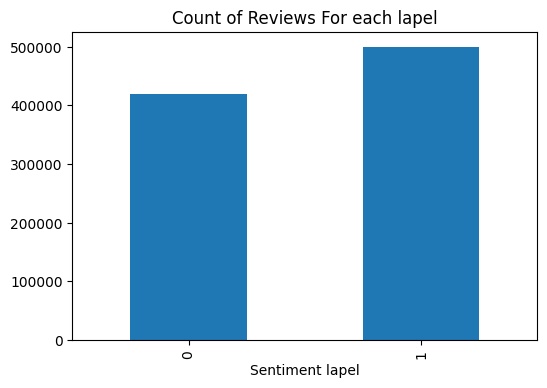

In [22]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews For each lapel',
          figsize=(6, 4))
ax.set_xlabel('Sentiment lapel')
plt.show()

In [23]:
df = df.drop(['podcast_id', 'author_id', 'created_at'], axis=1)
df.head()

,title,content,rating
0,Finally the podcast for 1%ers,Been waiting a long time for this podcast to c...,1
1,I love you Chris,"I am genuinely emotional, brought to crocodile...",1
2,So fetch.,I saw Art History Babes podcast wearing army p...,1
3,GREAT HUNTING PODCAST,My go to whitetail podcast. Only negative is I...,1
4,Can’t get enough!!,I am so glad to be a card carrying 1159 Patreo...,1


In [28]:
df_title = df.drop(['content'], axis=1)
df_title = df_title.rename(columns={'title': 'content'})
df_title.head()

,content,rating
0,Finally the podcast for 1%ers,1
1,I love you Chris,1
2,So fetch.,1
3,GREAT HUNTING PODCAST,1
4,Can’t get enough!!,1


In [29]:
df = pd.concat([df_title, df], ignore_index=True)

In [32]:
df = df.drop(['title'], axis=1)
df.head()

,content,rating
0,Finally the podcast for 1%ers,1
1,I love you Chris,1
2,So fetch.,1
3,GREAT HUNTING PODCAST,1
4,Can’t get enough!!,1


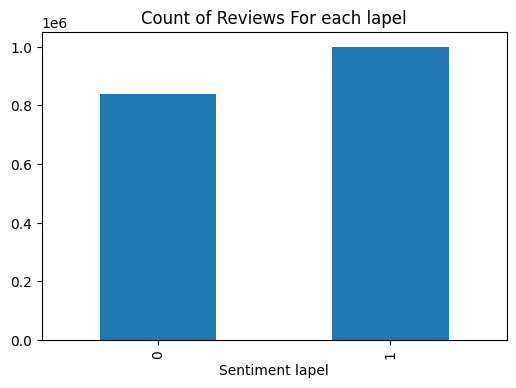

In [33]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews For each lapel',
          figsize=(6, 4))
ax.set_xlabel('Sentiment lapel')
plt.show()

In [34]:
df = df.rename(columns={'content': 'text', 'rating': 'label'})

# Preprocessing text

In [35]:
text = df['text'][0]
text

'Finally the podcast for 1%ers'

In [36]:
# Download the 'stopwords' resource
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\mohamed
[nltk_data]     mowina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\mohamed
[nltk_data]     mowina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')  # Download WordNet data

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

print('Limitized text: ', lemmatize_text(text))

[nltk_data] Downloading package wordnet to C:\Users\mohamed
[nltk_data]     mowina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Limitized text:  ['Finally', 'the', 'podcast', 'for', '1%ers']


In [39]:
from transformers import BertTokenizer#
#Tokenize using BERT tokenizer (optional, replace with your desired tokenizer)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [45]:
import emoji

def emoji_to_text(input_text):
    # Replace emojis with their textual representation
    text_with_emojis = emoji.demojize(input_text)
    return text_with_emojis

In [46]:
from nltk.corpus import wordnet

# Sample text
text = df['text'][0]

# Convert emoji to text
text = emoji_to_text(text)
print("Text without emojies:", text)

# Tokenize the text (split into words)
words = tokenizer.tokenize(text)

# Create a WordNet lemmatizer object
lemmatizer = WordNetLemmatizer()

# Lemmatize each word (convert to base form)
lemmatized_words = []
for word in words:
  # Lowercase the word for consistency
  lowercased_word = word.lower()
  # Get the lemma (base form) using pos_tag to determine the word type (e.g., noun, verb)
  lemma = lemmatizer.lemmatize(lowercased_word, pos='n')  # Use 'v' for verbs, etc. 
  lemmatized_words.append(lemma)

# Join the lemmatized words back into a string
lemmatized_text = " ".join(lemmatized_words)

print("Original Text:", text)
print("Lemmatized Text:", lemmatized_text)


Text without emojies: Finally the podcast for 1%ers
Original Text: Finally the podcast for 1%ers
Lemmatized Text: finally the podcast for 1 % er ##s


In [47]:
# Load stop words
stop_words = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
  """Applies preprocessing steps to the given text."""
  # Lowercase text
  text = text.lower()

  # Convert emoji to text
  text = emoji_to_text(text)
  
  # Remove numbers (optional)
  text = re.sub('[0-9]+', '', text)

  # Remove special characters, punctuation including %, ., and ,
  text = re.sub(r"[^\w\s!@#\$*\(\)_\+=\^:\\]", " ", text)  # Preserve negation words

  # Lemmatization (preferred)
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  # Clean URLs
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)

  # Clean Emails
  text = re.sub('@[^\s]+', ' ', text)
  
  # Stop word removal (optional)
  text = ' '.join([word for word in text.split() if word not in stop_words])

  return text


In [48]:
# Preprocess the sample text
preprocessed_text = preprocess_text(text)
print("Preprocessed text:", preprocessed_text)

tokens = tokenizer.tokenize(preprocessed_text)
print("BERT tokens:", tokens)

Preprocessed text: finally podcast er
BERT tokens: ['finally', 'podcast', 'er']


In [49]:
df['text'] = df['text'].astype(str)

# Clean text
df['text'] = df['text'].apply(lambda text: preprocess_text(text))

# Tokenize the preprocessed text
df['tokens'] = df['text'].apply(lambda text: tokenizer.tokenize(text))

# Convert tokens to ids (vectorization)
df['input_ids'] = df['tokens'].apply(lambda tokenized_text: tokenizer.convert_tokens_to_ids(tokenized_text))
df.head()

,text,label,tokens,input_ids
0,finally podcast er,1,"[finally, podcast, er]","[2633, 16110, 9413]"
1,love chris,1,"[love, chris]","[2293, 3782]"
2,fetch,1,[fetch],[18584]
3,great hunting podcast,1,"[great, hunting, podcast]","[2307, 5933, 16110]"
4,get enough!!,1,"[get, enough, !, !]","[2131, 2438, 999, 999]"


In [50]:
df.head()

,text,label,tokens,input_ids
0,finally podcast er,1,"[finally, podcast, er]","[2633, 16110, 9413]"
1,love chris,1,"[love, chris]","[2293, 3782]"
2,fetch,1,[fetch],[18584]
3,great hunting podcast,1,"[great, hunting, podcast]","[2307, 5933, 16110]"
4,get enough!!,1,"[get, enough, !, !]","[2131, 2438, 999, 999]"


In [51]:
df_cleaned = df[['input_ids', 'label']]
df_cleaned.head()

,input_ids,label
0,"[2633, 16110, 9413]",1
1,"[2293, 3782]",1
2,[18584],1
3,"[2307, 5933, 16110]",1
4,"[2131, 2438, 999, 999]",1


In [52]:
unique_labels = df_cleaned['label'].unique()
unique_labels

array([1, 0], dtype=int64)

In [53]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838284 entries, 0 to 1838283
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   input_ids  object
 1   label      int64 
dtypes: int64(1), object(1)
memory usage: 28.1+ MB


# Build RNN model

In [54]:
# Imports
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [55]:
# Drop null values
df_cleaned.dropna(inplace=True)

# Check unique values in the 'label' column
unique_labels = df_cleaned['label'].unique()
print(unique_labels)

[1 0]


In [56]:
# Hyperparameters
max_len = 200
vocab_size = 50000
embedding_dim = 128
learning_rate = 0.001
dropout_rate = 0.5
num_lstm_units = 128
num_dense_units = 64

# Split data into train, validation, and test sets
X = df_cleaned['input_ids']
y = df_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


In [57]:
# Convert input data to numpy arrays and pad sequences
X_train_padded = pad_sequences(X_train.values, maxlen=max_len)
X_val_padded = pad_sequences(X_val.values, maxlen=max_len)
X_test_padded = pad_sequences(X_test.values, maxlen=max_len)

In [58]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model definition
model = Sequential()

# Embedding layer
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

# LSTM layer
model.add(LSTM(num_lstm_units, dropout=dropout_rate))

# Dense layers
model.add(Dense(num_dense_units, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(filepath='podcasts_rnn_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
hist = model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_data=(X_val_padded, y_val),
                     callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
51702/51702 [==============================] - 1611s 31ms/step - loss: 0.2729 - accuracy: 0.8839 - val_loss: 0.2505 - val_accuracy: 0.8948
Epoch 2/20
51702/51702 [==============================] - 1625s 31ms/step - loss: 0.2458 - accuracy: 0.8981 - val_loss: 0.2453 - val_accuracy: 0.8981
Epoch 3/20
51702/51702 [==============================] - 1623s 31ms/step - loss: 0.2383 - accuracy: 0.9021 - val_loss: 0.2433 - val_accuracy: 0.8987
Epoch 4/20
51702/51702 [==============================] - 1607s 31ms/step - loss: 0.2349 - accuracy: 0.9041 - val_loss: 0.2426 - val_accuracy: 0.8996
Epoch 5/20
51702/51702 [==============================] - 1610s 31ms/step - loss: 0.2330 - accuracy: 0.9054 - val_loss: 0.2435 - val_accuracy: 0.8994
Epoch 6/20
51702/51702 [==============================] - 1606s 31ms/step - loss: 0.2319 - accuracy: 0.9059 - val_loss: 0.2450 - val_accuracy: 0.8995
Epoch 7/20
51702/51702 [==============================] - 1597s 31ms/step - loss: 0.2313 - accuracy:

In [59]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

11490/11490 [==============================] - 141s 12ms/step - loss: 0.2309 - accuracy: 0.9059
Test Loss: 0.23086220026016235
Test Accuracy: 0.905896008014679


In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,539,905
Trainable params: 6,539,905
Non-trainable params: 0
_________________________________________________________________


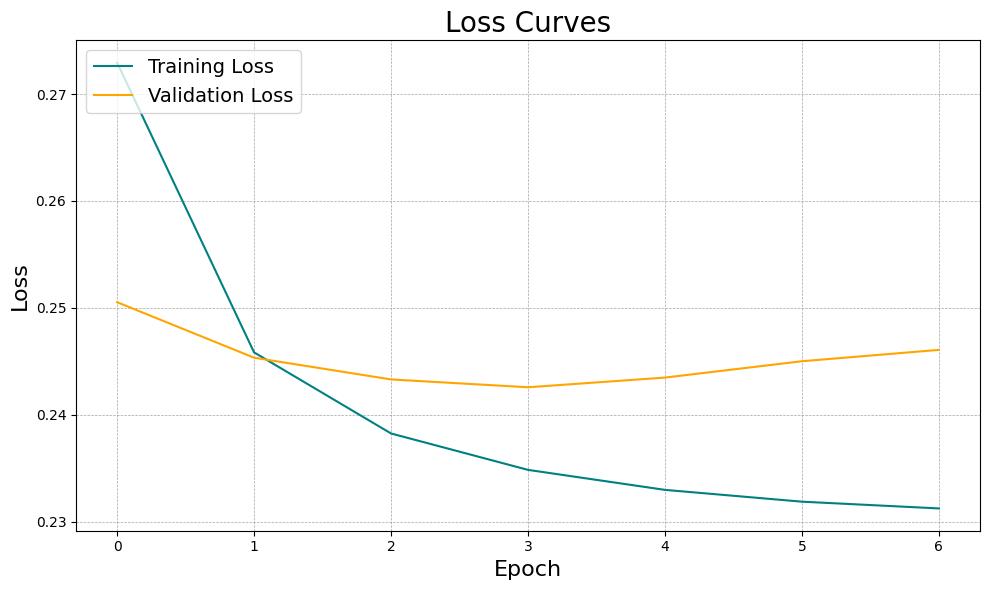

In [61]:
# Create the figure and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed
ax.plot(hist.history['loss'], color='teal', label='Training Loss')  # Rename labels
ax.plot(hist.history['val_loss'], color='orange', label='Validation Loss')

# Customize plot elements
ax.set_title('Loss Curves', fontsize=20)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(loc='upper left', fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)  # Add grid lines

# Display the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


## Implemintaion

In [62]:
from tensorflow.keras.models import load_model

# Path to your h5 model file
model_path = 'podcasts_rnn_model.h5'

# Load the model
model = load_model(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [63]:
def predict_sentiment(text, model = model, tokenizer = tokenizer, max_len = max_len):
  """Predicts sentiment for a given text using the provided model and tokenizer.

  Args:
      text: The text to predict sentiment for (string).
      model: The trained sentiment analysis model.
      tokenizer: The tokenizer used to preprocess the text.
      max_len: The maximum sequence length for the model (integer).

  Returns:
      A tuple containing:
          - predicted_sentiment: The predicted sentiment score (float).
          - sentiment_label: The sentiment label based on a threshold (string).
  """

  # Preprocess the text
  preprocessed_text = preprocess_text(text)  # Replace with your preprocessing function

  # Tokenize the text
  tokens = tokenizer.tokenize(preprocessed_text, padding='max_length', truncation=True)

  # Convert tokens to IDs
  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # Pad the sequence (if model requires it)
  padded_input = pad_sequences([input_ids], maxlen=max_len)

  # Make the prediction
  predicted_sentiment = model.predict(padded_input)[0][0]  # Assuming single output

  # Define a threshold for sentiment classification (optional)
  threshold = 0.5  # Adjust threshold based on your model's output range

  sentiment_label = 'Positive' if predicted_sentiment > threshold else 'Negative'

  return predicted_sentiment, sentiment_label



In [ ]:
ex_text = input('Text:')

In [64]:
ex_text = "The first one I bought was defective. The DVD didn't work at all. I purchased it from Electronics Express and when I contacted them they were wonderful. They gave me an RMA number right away, Fedex picked it up the next day and a new one arrived 1 week later. This one is just fine. I really love the clarity of the picture. My only complaint is that in DVD mode, the sound isn't loud enough. I have it in my RV and with the A/C running, I can barely hear it. I solved the problem by running an audio out jack from the TV to the input on the RV stereo speaker system. It's very lightweight and easy to move around and store. A bonus for the RV. The remote isn't great, but it works just fine and the video/audio jacks and antenna input are easy to get to as is the DVD player. All in all, it's a great deal for the price."
predict_sentiment(text= ex_text, model= model, tokenizer= tokenizer, max_len= 200)

Keyword arguments {'padding': 'max_length', 'truncation': True} not recognized.


1/1 [==============================] - 1s 800ms/step


(0.8752216, 'Positive')